In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import yaml
from Prithvi_100M.Prithvi import MaskedAutoencoderViT

NO_DATA = -9999
NO_DATA_FLOAT = 0.0001
PERCENTILES = (0.1, 99.9)


def load_raster(path,channel=[1,2,3,8,11,12], crop=None):
    with rasterio.open(path) as src:
        img = src.read()

        # load first 6 bands
        img = img[channel]

        img = np.where(img == NO_DATA, NO_DATA_FLOAT, img)
        if crop:
            img = img[:, -crop[0]:, -crop[1]:]
    return img

def enhance_raster_for_visualization(raster, ref_img=None):
    if ref_img is None:
        ref_img = raster
    channels = []
    for channel in range(raster.shape[0]):
        valid_mask = np.ones_like(ref_img[channel], dtype=bool)
        valid_mask[ref_img[channel] == NO_DATA_FLOAT] = False
        mins, maxs = np.percentile(ref_img[channel][valid_mask], PERCENTILES)
        normalized_raster = (raster[channel] - mins) / (maxs - mins)
        normalized_raster[~valid_mask] = 0
        clipped = np.clip(normalized_raster, 0, 1)
        channels.append(clipped)
    clipped = np.stack(channels)
    channels_last = np.moveaxis(clipped, 0, -1)[..., :3]
    rgb = channels_last[..., ::-1]
    return rgb


In [8]:
########################### check saved validation image from burn scar epoch wise #############################
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import math


# List all files in the directory
#files = os.listdir(folder_path)

# Filter out non-image files (you can add more extensions if needed)
#image_files = [f for f in files if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

'''
# Check how many images are in the folder
num_images = len(image_files)
print(f"Number of images in the folder: {num_images}")

row=math.floor(math.sqrt(num_images))
# Plot the images together

fig, axes = plt.subplots(row, row, figsize=(15, 5))

# If there's only one image, axes won't be a list, so handle that case
if num_images == 1:
    axes = [axes]

n_image=int(row*row)
i=1
'''

'''
for ax, image_file in zip(axes, image_files):
    img_path = os.path.join(folder_path, image_file)
    '''
######################################################## IMAGE visualization ############################################################
def image_vis(raster_path_original):
    
    original_data = load_raster(raster_path_original,channel=[8,11,12],crop=[224,224])
    raster_for_visualization = enhance_raster_for_visualization(original_data)
    #print(raster_for_visualization.shape)
    return raster_for_visualization


################################################    Target Mask Visualization ##############################################
def mask_vis(raster_path_target):
    
    mask_data = load_raster(raster_path_target,channel=[0],crop=[224,224])
    mask_data = np.where(mask_data == -1, 0, mask_data)
    values=np.array(mask_data)
    print("unique classes in mask",np.unique(values))
    #print(f"mask data is {mask_data}")
    #print(f"mask data shape is {mask_data.shape}")
    return mask_data

################################################ Pred Mask visualization #####################################################
def pred_vis(pred_mask_path):
    pred_mask = Image.open(pred_mask_path)
    # Convert image to grayscale if required
    pred_mask = pred_mask.convert("L") if pred_mask.mode != "L" else pred_mask
    return pred_mask


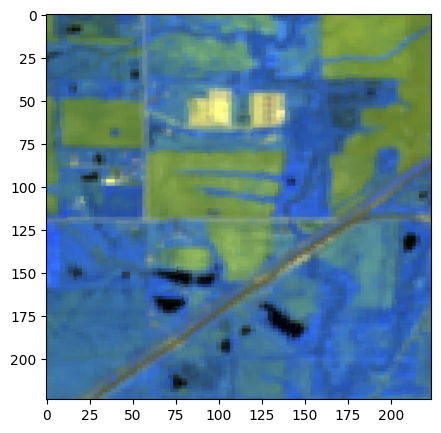

In [9]:
raster_path_original = "/rhome/rghosal/flood_map/v1.1/data/flood_events/HandLabeled/S2Hand/USA_1010394_S2Hand.tif"
image_original=image_vis(raster_path_original)
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(image_original)

plt.show()



unique classes in mask [0. 1.]


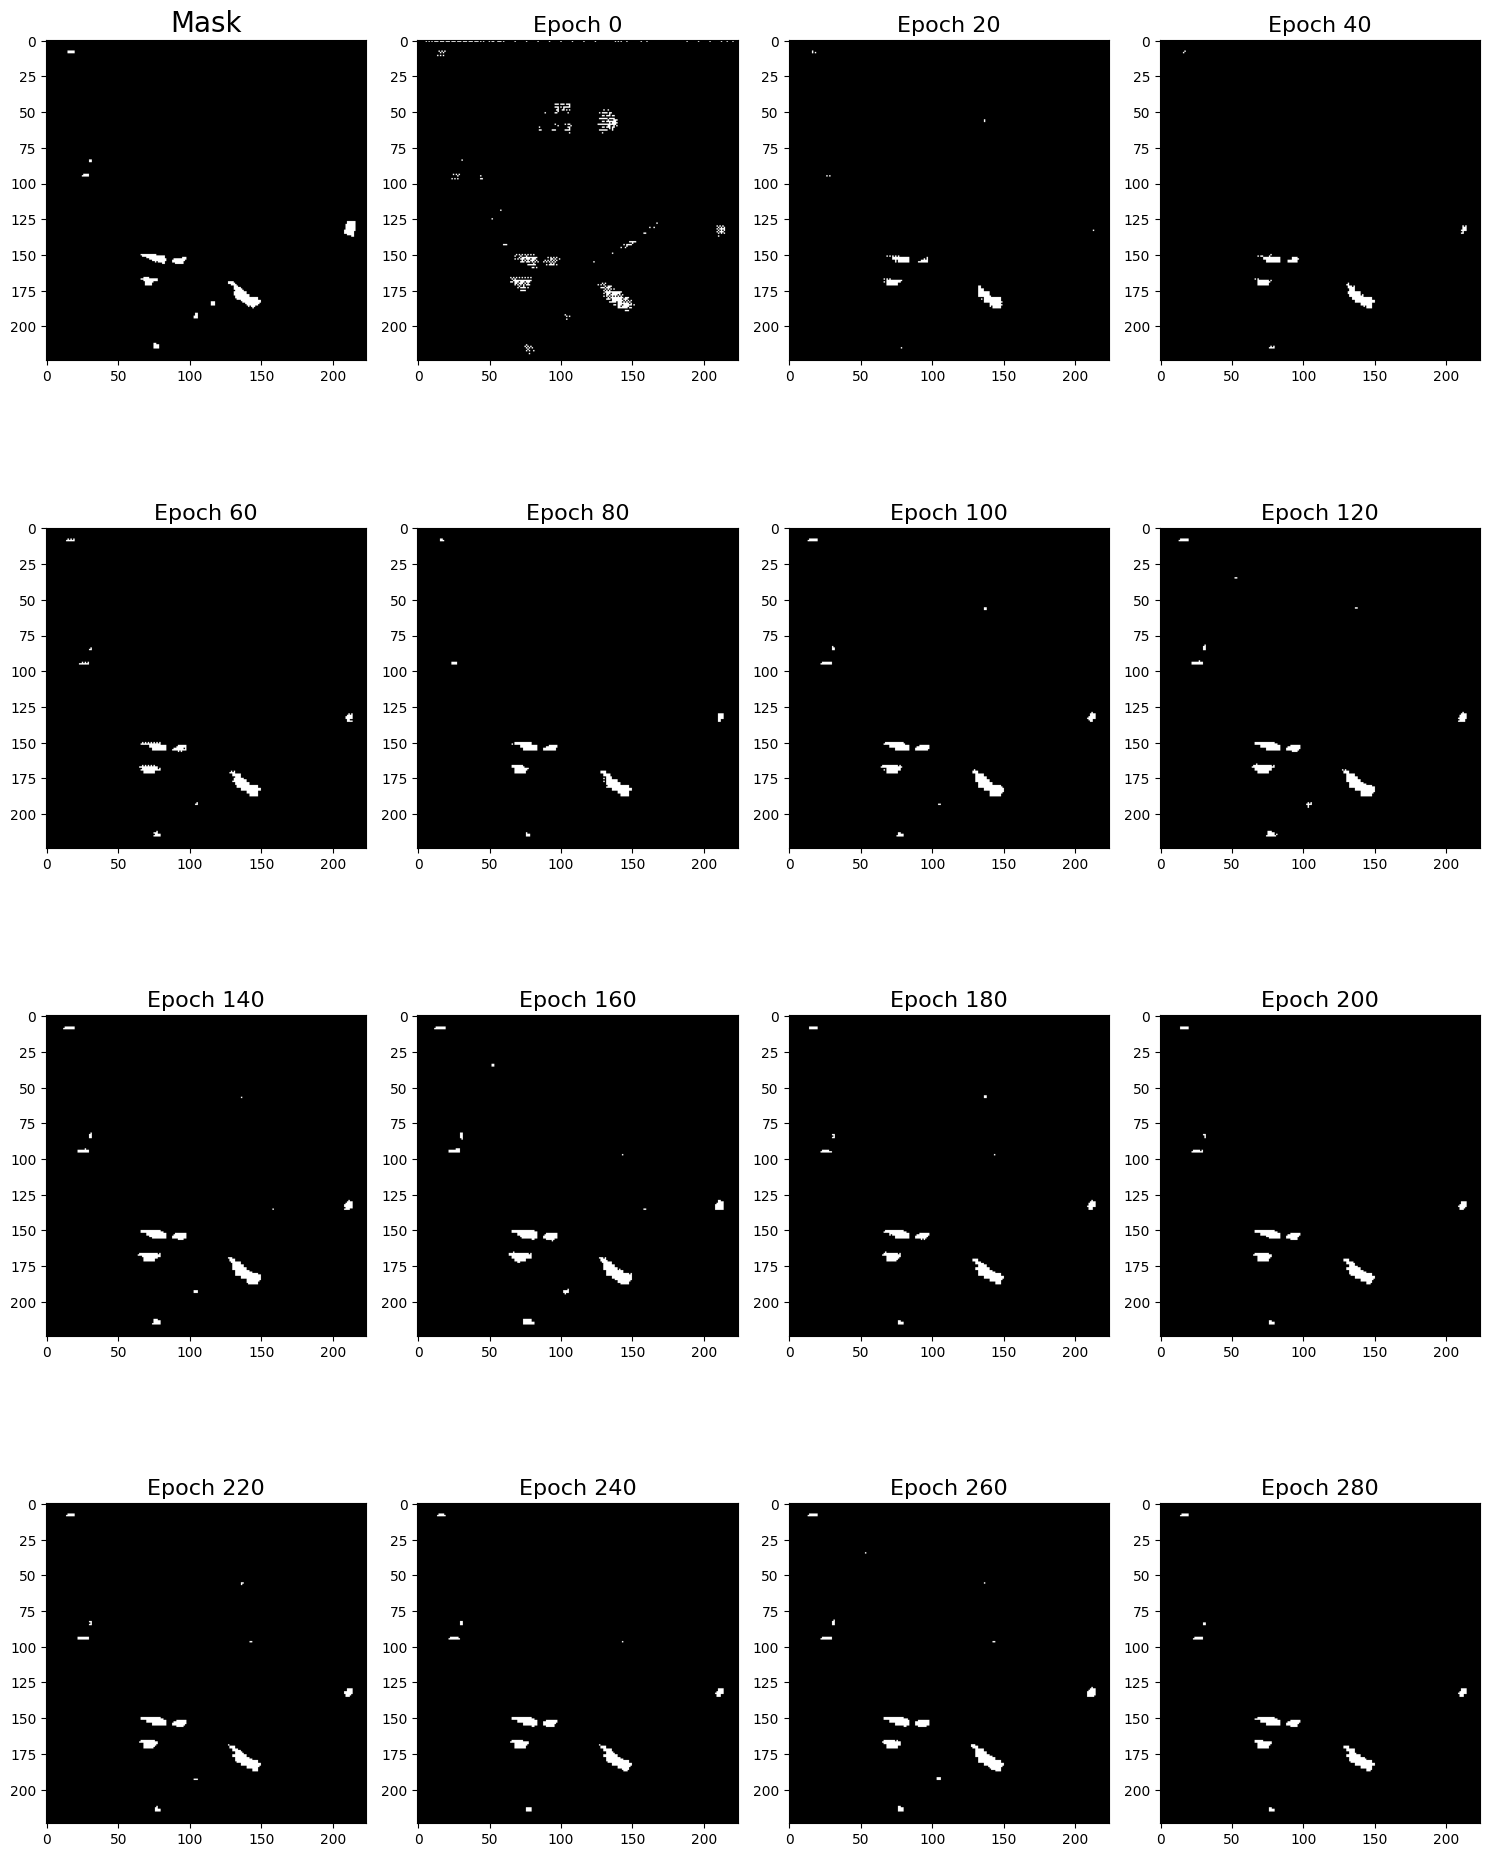

In [138]:
import matplotlib.pyplot as plt
import math

# Initialize variables
epoch = 0
i = 2
n_image = 300 // 20 + 1  # Total number of images
rows = math.ceil(n_image / 4)  # Number of rows (4 images per row)
cols = min(4, n_image)  # Number of columns (up to 4 images per row)

# Create a figure to hold the subplots
plt.figure(figsize=(15, rows * 5))
raster_path_target = "/rhome/rghosal/flood_map/v1.1/data/flood_events/HandLabeled/LabelHand/USA_1010394_LabelHand.tif"
mask=mask_vis(raster_path_target)
plt.subplot(rows,cols,1)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title(f"Mask",fontsize=20)

while epoch < 300:
    #print("Epoch start:", epoch)
    
    # Generate the path to the predicted mask for the current epoch
    pred_mask_path = f"/rhome/rghosal/Rinki/rinki-hls-foundation-os/prithvi_merra/new_flood/segment_out_new_flood/segmentation5_output_epoch_{epoch}.png"
    
    try:
        # Assuming pred_vis is a function that loads the mask from the path
        pred_mask = pred_vis(pred_mask_path)
    except FileNotFoundError:
        print(f"File not found for epoch {epoch}: {pred_mask_path}")
        break  # or continue if you want to skip the missing files and keep processing
    
    # Plot the predicted mask
    
    plt.subplot(rows, cols, i)
    plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=255)
    plt.title(f"Epoch {epoch}", fontsize=16)  # Increase the font size of the title
    
    # Increment the epoch and subplot index
    epoch += 20
    i += 1
    
    #print("Epoch end:", epoch)

# Adjust layout and display the figure
plt.tight_layout()
plt.show()